# Трансформация и поворот по ключевым точкам
Используем дескрипторы SIFT для трансформации (поворота, наклона) изображения по шаблону

* Изображение: https://video.ittensive.com/machine-vision/car.number.example.small.jpg
* Шаблон: https://video.ittensive.com/machine-vision/car.number.template.small.png

![Гомография](homography.jpg)

### Подключение библиотек

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Загрузка изображений
Основное изображение и шаблон

In [2]:
image = cv2.imread("car.number.example.small.jpg")
pattern = cv2.imread("car.number.template.small.png")

In [3]:
def show_image (img, gray=False):
    fig = plt.figure(figsize=(16,8))
    plt.axis("off")
    if gray:
        plt.imshow(img, cmap="Greys")
    else:
        plt.imshow(img[...,::-1])
    plt.show()

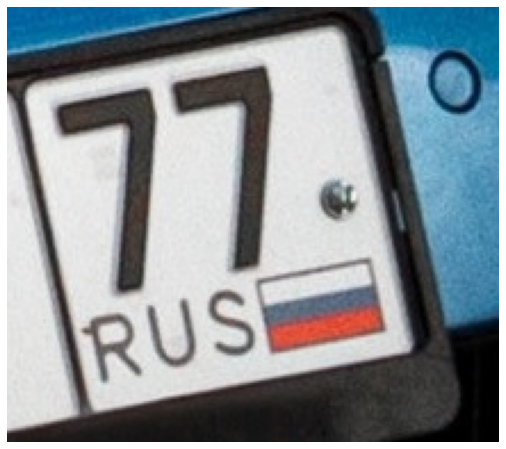

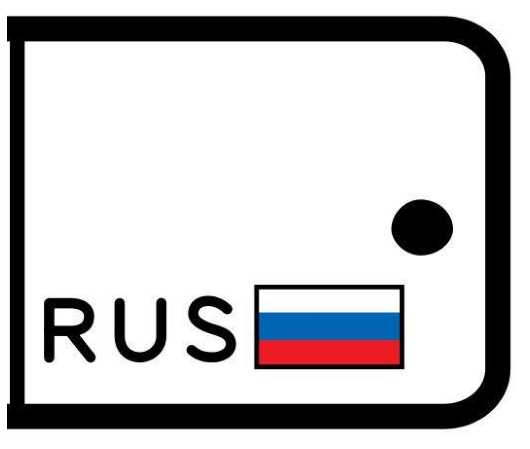

In [4]:
show_image(image)
show_image(pattern)

### Фильтрация изображения

In [5]:
def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

def filter_image (img, small=False):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (100,100))
    img = cv2.GaussianBlur(img, (3,3), 10)
    img = cv2.fastNlMeansDenoising(img, h=10)
    img = unsharp_mask(img)
    return img

In [6]:
pattern_thresh = filter_image(pattern, small=True)
image_thresh = filter_image(image)

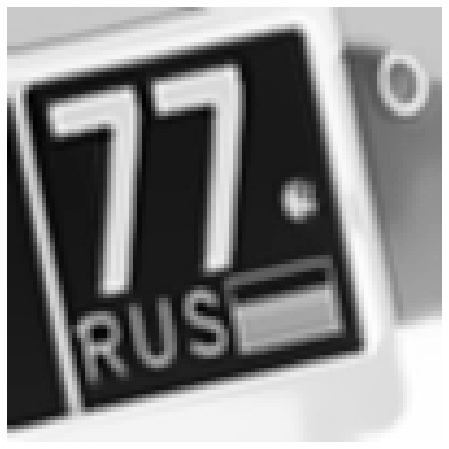

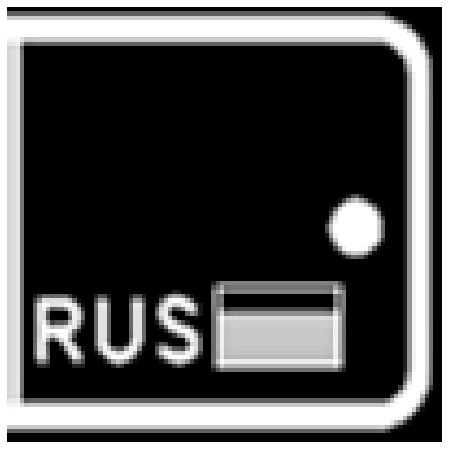

In [7]:
show_image(image_thresh, True)
show_image(pattern_thresh, True)

### Детекторы ключевых точек
Создаем детекторы для шаблонного изображения (ограничиваем особенности), а затем - для анализируемого

In [8]:
#orb = cv2.ORB_create(1000)
orb = cv2.xfeatures2d.SIFT_create()

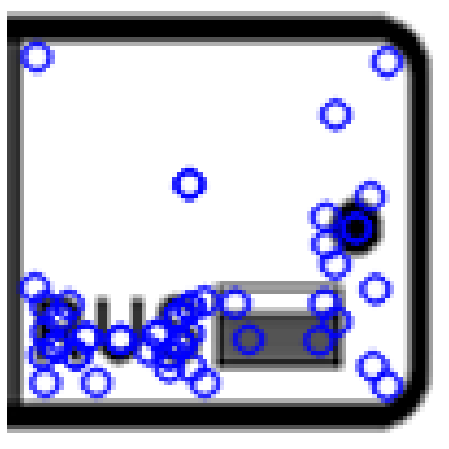

Ключевые точки: 51


In [9]:
pattern_kp, pattern_des = orb.detectAndCompute(pattern_thresh, None)
show_image(cv2.drawKeypoints(pattern_thresh, pattern_kp, pattern_thresh, color=(255, 0, 0)))
print ("Ключевые точки:", len(pattern_kp))

In [10]:
kp, des = orb.detectAndCompute(image_thresh, None)

### Вычисление совпадений
FLANN - для SIFT/SURF, BruteForce - для BRIEF/ORB

In [11]:
matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
#matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
matches = matcher.match(pattern_des, des, None)
#matches = matcher.knnMatch(pattern_des, des, k=3)
print ("Совпадений: ", len(matches))

Совпадений:  51


In [12]:
if len(matches) > 200:
    matches.sort(key=lambda x: x.distance, reverse=False)
    matches = matches[:100]

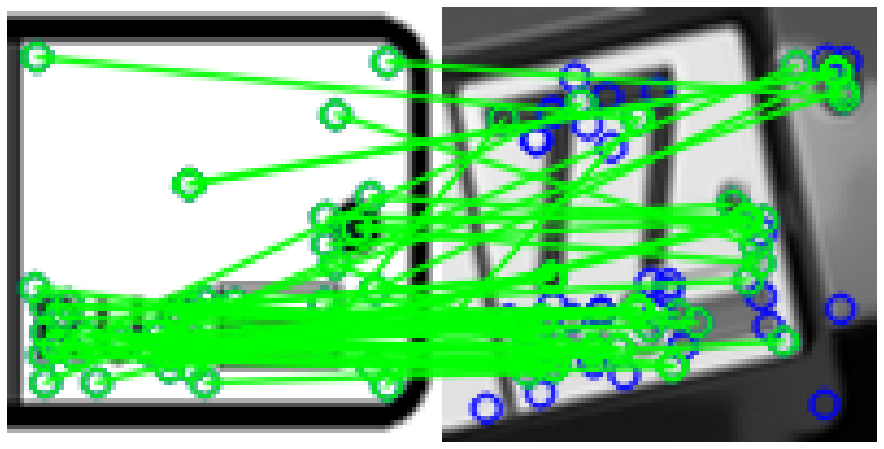

In [13]:
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i,match in enumerate(matches):
    points1[i, :] = kp[match.trainIdx].pt
    points2[i, :] = pattern_kp[match.queryIdx].pt

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   flags = 0)

show_image(cv2.drawMatches(pattern_thresh, pattern_kp, image_thresh, kp, matches, None, **draw_params))

### Преобразование изображения
Находим гомографию: коэффициенты поворота/смещения

In [14]:
#a = cv2.getAffineTransform(pts1, pts2)
h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
print (h)

[[ 9.21952986e-01 -2.09869750e-01  6.80057081e+00]
 [ 4.98704605e-02  7.99778573e-01  2.11674261e+00]
 [-1.83406196e-03 -9.73062466e-04  1.00000000e+00]]


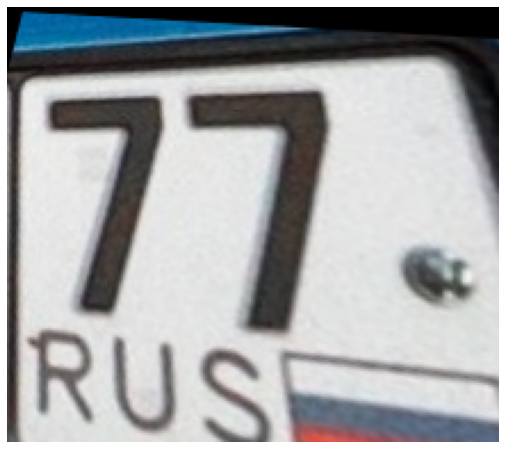

In [15]:
image_transformed = cv2.warpPerspective(image, h, (image.shape[1], image.shape[0]))
show_image(image_transformed)